# Collaborative Multi-Agent System with LangGraph
* Notebook by Adam Lang
* Date: 11/1/24

# Overview
* In this notebook project I am going to build a collaborative multi-agent system using LangGraph.

# What is a Multi-Agent System?
* A system in which multiple agents collaborate or work independently to solve specific tasks.
* Microsoft's Original Paper: https://arxiv.org/abs/2308.08155

# Multi-Agent Workflow
1. Step 1 - User Query
  * User gives query to multi-agent system.

2. Step 2 - Research Agent Node
  * Uses web search tool to get info from web for user query.

3. Step 3 - Chart Generator Agent Node
  * Uses python code and takes data from researcher node to build data visualization.

* This is the Agent flow diagram:
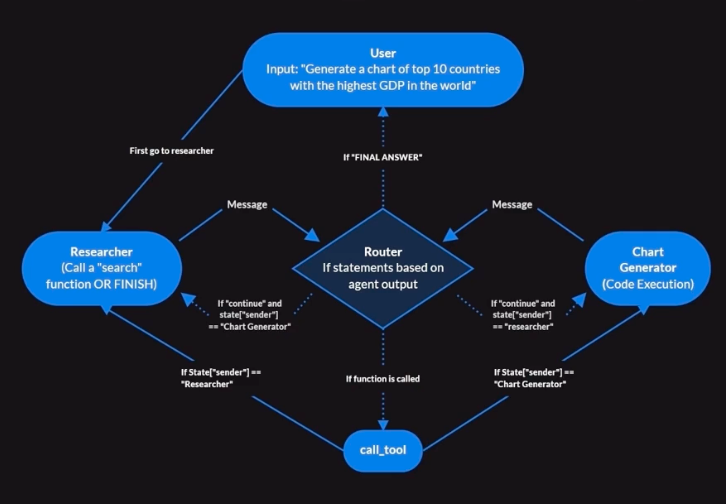

Note:
* This is similar to "building a team of data scientists" using agents.

4. Step 4 - Routing Node
  * If some information is missing for visualization go back to researcher node to get more data.

5. Step 5 - Routing Node
  * If any new info is obtained from researcher go to the chart generator node to recreate visualiation.

6. Step 6 - END Node
  * If visualization is successfully created end agent run.

# Building a Collaborative Multi-Agent System in LangGraph
* A single agent can usually operate effectively using a handful of tools within a single domain but even using powerful LLMs it can be less effective at using many tools.
* Thus the best way to fix this is to use the **"divide-and-conquer" approach** which we discussed above inspired by the AutoGen framework from the original Microsoft paper.
* Typical workflow:

1. **Research Agent** which can leverage tools like search to get LIVE informaiton from user queries.

2. **Chart Generator Agent** which is an expert in taking data and building visualizations in Python.

3. **Router** which will help in calling the right agent and tools based on current state in agent.

## Install Dependencies

In [1]:
!pip install langchain==0.2.0
!pip install langchain-openai==0.1.7
!pip install langchain-community==0.2.0
!pip install langgraph==0.1.1
!pip install langchain-experimental==0.0.62

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 973.7/973.7 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.1/397.1 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.6 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.13
    Uninstalling langchain-core-0.3.13:
      Successfully uninstalled langchain-core-0.3.13
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 0.3.0
    Uninstalling langchain-text-splitters-0.3.0:
      Successfully uninstalled langchain-text-splitters-0.3.0
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.4
    Uninstalling langchain-0.3.4:
      Successfully uninstalled langchain-0.3.4
   ━━━━━━━━━━━━━━━━━━━━━━

## Enter Open AI API key

In [2]:
from getpass import getpass

OPENAI_KEY = getpass("Enter Open AI API Key: ")

Enter Open AI API Key: ··········


## Enter Tavily Search API Key

In [3]:
TAVILY_API_KEY = getpass('Enter Tavily Search API Key: ')

Enter Tavily Search API Key: ··········


## Setup Environment Variables

In [4]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

# Build Collaborative Multi-Agent System
* Here we build key components of our collaborative multi-agent system.

## Create Tools
* Here we will be using the Tavily API for our web searches.
* Here is the link: https://docs.tavily.com/docs/rest-api/api-reference

In [5]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

## setup tavily search
tv_search = TavilySearchResults(max_results=5,
                                search_depth='advanced',
                                max_tokens=10000)

# repl -- https://python.langchain.com/docs/integrations/tools/python/
repl = PythonREPL()
@tool
def python_repl(code: Annotated[str, "The python code to execute to generate your chart."],):
  """Use this to execute python code.
    If you want to see the output of a value,
    you should print it out with `print(...)`.

    This is visible to the user."""
  try:
    result = repl.run(code)
  except BaseException as e:
    return f"Failed to execute. Error: {repr(e)}"
  result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
  return (result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER.")


## Graph State
* We first define the state of the graph.
* This will just list messages, along with a key to track the most recent sender.

In [6]:
import operator
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage

# this defines the object thta is passed between each node
# in the graph we will create different nodes for each agent and tool
class AgentState(TypedDict):
  messages: Annotated[Sequence[BaseMessage], operator.add]
  sender: str

## Create Agents
* We will create 2 main agents:
1. Research Agent
  * Can access web search tool to make web searches to get information on user queries.
  
2. Chart Agent
  * Can use python to create data visualizations.

In [7]:
## imports
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

## init LLM of choice
llm = ChatOpenAI(model="gpt-4o")

## tool setup
search_tool = [tv_search]
search_tool_name = tv_search.name
research_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", f"""You are a helpful AI assistant, collaborating with other assistants.
                   Use the provided tools to progress towards answering the question.
                   If you are unable to fully answer, that's OK,
                   another assistant with different tools will help where you left off.
                   Execute what you can to make progress.
                   If you or any of the other assistants have the final answer or deliverable,
                   prefix your response with FINAL ANSWER so the team knows to stop.

                   You have access to the following tools:
                   {search_tool_name}

                   You should provide accurate data for the chart_generator to use.
                   """,

        ),
        MessagesPlaceholder(variable_name="messages"),

    ]
)
## connect prompt to llm
research_agent = (research_prompt
                      |
                  llm.bind_tools(search_tool))

#chart tool
chart_tool = [python_repl]
chart_tool_name = python_repl.name
chart_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", f"""You are a helpful AI assistant, collaborating with other assistants.
                   Use the provided tools to progress towards answering the question.
                   If you are unable to fully answer, that's OK,
                   another assistant with different tools will help where you left off.
                   Execute what you can to make progress.
                   If you or any of the other assistants have the final answer or deliverable,
                   prefix your response with FINAL ANSWER so the team knows to stop.

                   You have access to the following tools:
                   {chart_tool_name}

                   Run the python code to display the chart.
                   """,
        ),
        MessagesPlaceholder(variable_name="messages"),



    ]
)
# connect prompt to llm
chart_agent = (chart_prompt
                  |
               llm.bind_tools(chart_tool))

## Define Agent Nodes
* These functions will actually call the agents as necessary and update the state in the agent.

In [8]:
from langchain_core.messages import ToolMessage, AIMessage

## research agent node
def research_agent_node(state):
  result = research_agent.invoke(state)
  # convert agent output into format suitable to append to global state
  if isinstance(result, ToolMessage):
    pass
  else:
    result = AIMessage(**result.dict(exclude={"type", "name"}), name="Researcher")
  return {
      "messages": [result],
      # since we have strict workflow, we can track sender so we know who to pass to next
      "sender": "Researcher",

  }

## chart agent node
def chart_agent_node(state):
  result = chart_agent.invoke(state)
  # convert agent output into format suitable to append to global state
  if isinstance(result, ToolMessage):
    pass
  else:
    result = AIMessage(**result.dict(exclude={"type", "name"}), name="chart_generator")
  return {
    "messages": [result],
    # since we have strict workflow we can track sender so we know who to pass to next
    "sender": "chart_generator",


  }


## Define Tool Node
* Defines tools we would be using in multi-agent system.

In [9]:
from langgraph.prebuilt import ToolNode

## init tools
tools = [tv_search, python_repl]
tool_node = ToolNode(tools)

## Define Edge Logic
* Defines some of conditional edge logic that is needed to decide what to do based on results of agents.

In [10]:
# either agent can decide to end
from typing import Literal

## router function
def router(state) -> Literal["call_tool", "__end__", "continue"]:
  # this is the router
  messages = state["messages"]
  last_message = messages[-1]
  if last_message.tool_calls:
    # previous agent is invoking a tool
    return "call_tool"
  if "FINAL ANSWER" in last_message.content:
    # any agent decided work is done
    return "__end__"
  return "continue"

# Define Multi-Agent Graph
* We can put ALL the pieces together now and define the graph!

In [11]:
#imports
from langgraph.graph import END, StateGraph

# init state graph
agent = StateGraph(AgentState)

## add nodes
agent.add_node("Researcher", research_agent_node)
agent.add_node("chart_generator", chart_agent_node)
agent.add_node("call_tool", tool_node)

## add conditional edges -- logic
agent.add_conditional_edges(
    "Researcher",
    router,
    # routing map
    {"continue": "chart_generator", "call_tool": "call_tool", "__end__": END} # end of logic
)
agent.add_conditional_edges(
    "chart_generator",
    router,
    # routing map
    {"continue": "Researcher", "call_tool": "call_tool", "__end__": END},

)
agent.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    # routing map
    {"Researcher": "Researcher", "chart_generator": "chart_generator"},
)

## set graph entry point + compile agent
agent.set_entry_point("Researcher")
agent = agent.compile()

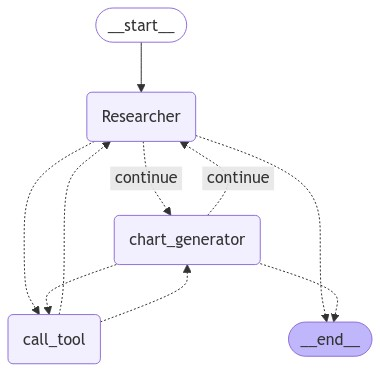

In [12]:
## display graph diagram
from IPython.display import Image, display, Markdown

display(Image(agent.get_graph().draw_mermaid_png()))


# Test the Multi-Agent System

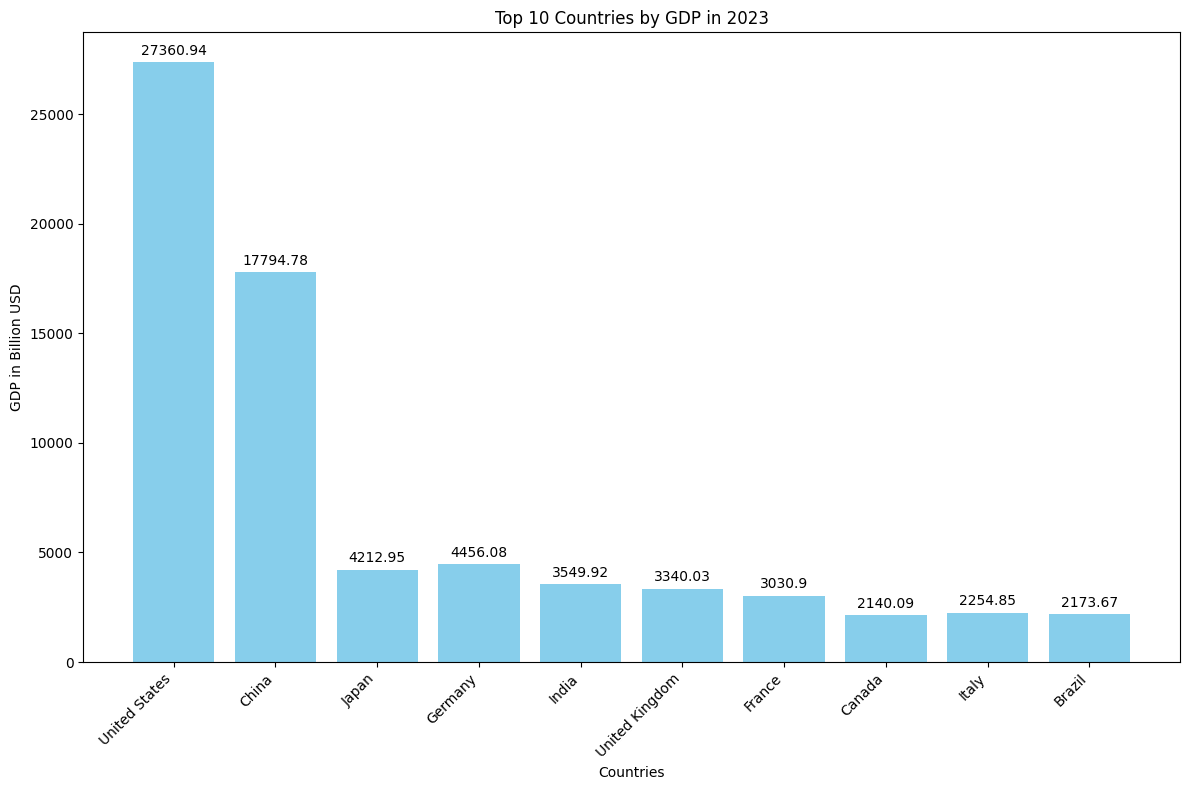

In [14]:
## test prompt
prompt = """Retrieve the data for the top 10 countries with the highest GDP in the world.
            Then use this data and draw a bar chart.
            Make sure the bar chart is labeled with the dollar amount of GDP on top of each bar.
            Make sure the bar chart is vertical not horizontal.
            Label the x axis as "Countries".
         """

## invoke response
response = agent.invoke({"messages": [('human', prompt)]},
                        # Max number of steps to take in graph
                        {"recursion_limit": 150},)

In [15]:
## view data and metadata response
response

{'messages': [('human',
   'Retrieve the data for the top 10 countries with the highest GDP in the world.\n            Then use this data and draw a bar chart.\n            Make sure the bar chart is labeled with the dollar amount of GDP on top of each bar.\n            Make sure the bar chart is vertical not horizontal.\n            Label the x axis as "Countries".\n         '),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_p5YKNHfgNcbGekRi7saBjeYY', 'function': {'arguments': '{"query":"top 10 countries by GDP 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 270, 'total_tokens': 296, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_45cf54deae', 'finish_reason': 'tool_calls', 'logprobs': None}, name='Researcher', id='ru

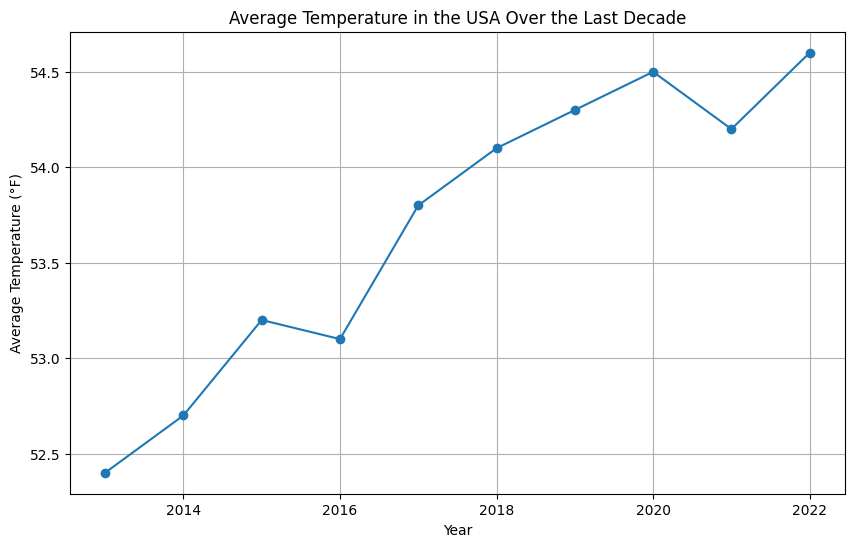

In [16]:
## test prompt 2
prompt = """Fetch data for the average temperature of USA over the last decade.
          Then use this data to draw a horizontal line chart.
          """
response = agent.invoke({"messages": [('human', prompt)]},
                        # max number of steps to take in graph
                        {"recursion_limit": 150},)

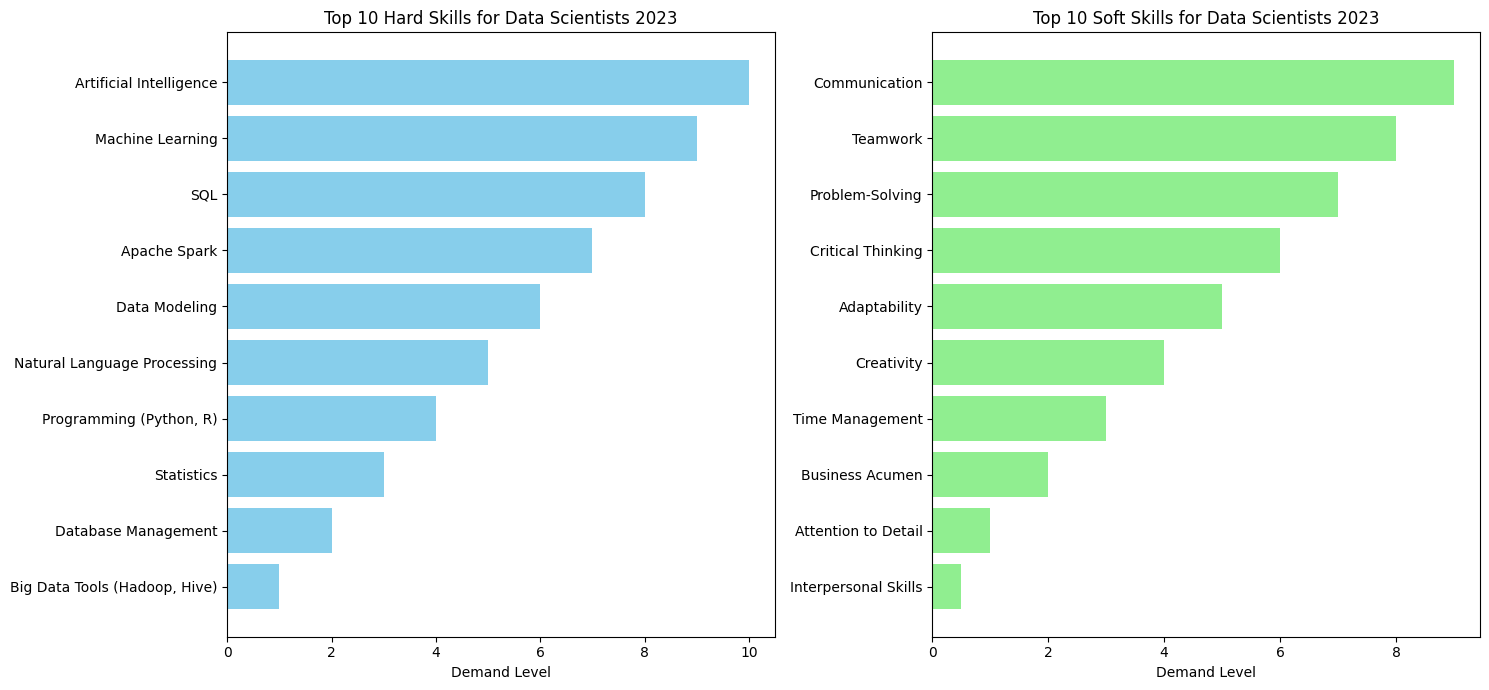

In [17]:
## test prompt 3
prompt = """Fetch data for the top 10 hard and soft skills for Data Scientists from the Lightcast API.
          Then use this data to draw a vertical bar graph of each of the skills.
          You can put the skills in 2 separate bar graphs side by side.
          """
response = agent.invoke({"messages": [('human', prompt)]},
                        # max number of steps to take in graph
                        {"recursion_limit": 150},)